In [1]:
%matplotlib inline

In [2]:
import matplotlib
matplotlib.rc('pdf', fonttype=42)

In [3]:
import pandas as pd
import numpy as np

# Timeline

In [4]:
#!curl 'http://localhost:5000/c/lv-final/tweets.jsonl?&filter=none' > all.jsonl

In [5]:
tweets = (
    pd.read_json('all.jsonl', orient='records', lines=True)
    .set_index(['created_at', 'language'], append=True)
    .sort_index()
)

In [6]:
tweets['count'] = 1

In [7]:
counts = tweets['count'].unstack('language').resample('1D', level='created_at').sum().fillna(0)

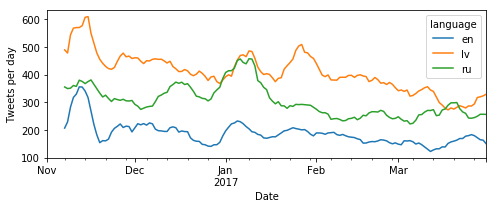

In [403]:
_ = (
    counts
    .rolling(window=7).mean()
    .plot(figsize=(7, 2.5))
)
_.set(xlabel="Date", ylabel="Tweets per day")
_.figure.tight_layout()
_.figure.savefig('figures/timeline.pdf')

In [9]:
counts.corr().loc[['lv', 'ru', 'en'], ['lv', 'ru', 'en']].round(3).to_latex('figures/timeline-lang-corr.tex')

# Language usage

In [64]:
sn_lang = (
    pd.read_csv(
        'screen_names-languages.csv',
        index_col='Screen name',
    )
    #.fillna(0)
    #.astype(int)
)

In [65]:
sn_lang = sn_lang[~pd.Series(sn_lang.index.get_values()).str.startswith('@@').values]

In [66]:
len(sn_lang)

507

In [375]:
lang_rank = sn_lang[['Latvian', 'Russian', 'English']].rank(axis='columns', method='min', ascending=False)

In [376]:
lang_preference = pd.concat(
    [
        lang_rank.apply((lambda r: r == 1), axis='columns').assign(**{'Preference': 'First'}),
        lang_rank.apply((lambda r: r == 2), axis='columns').assign(**{'Preference': 'Second'}),
        lang_rank.apply((lambda r: r == 3), axis='columns').assign(**{'Preference': 'Third'}),
    ],
).set_index('Preference', append=True).unstack('Preference')#.sum().unstack(0)
# lang_preference['# langs'] = lang_preference.sum(axis='columns')


## Monolingual

In [381]:
monolingual = lang_preference[lang_preference.sum(axis='columns') == 1].swaplevel(axis='columns')['First'].sum()
monolingual

Latvian    75
Russian    43
English    62
dtype: int64

In [382]:
monolingual.sum(), np.round(monolingual.sum() / len(sn_lang), 3) * 100

(180, 35.5)

## Multilingual 

In [379]:
# lang_preference.loc['djnickymiles'].unstack(0)

In [397]:
_ = lang_preference[lang_preference.sum(axis='columns') > 1].sum().unstack(0)
_.to_latex('figures/pre')
_

,Latvian,Russian,English
Preference,,,
First,150,135,42
Second,56,19,266
Third,29,26,9


## Score

In [384]:
sn_lang['Score'] = np.round(
    sn_lang[['Latvian', 'Russian', 'English']].max(axis='columns') / sn_lang['Total'],
    3,
)

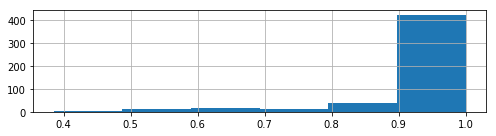

In [386]:
_ = sn_lang['Score'].hist(bins=6, figsize=(7, 2))
_.figure.tight_layout()
_.figure.savefig('figures/score-hist.pdf')

In [387]:
pd.cut(sn_lang['Score'], bins=6, retbins=True)[1]

array([ 0.384385,  0.4875  ,  0.59    ,  0.6925  ,  0.795   ,  0.8975  ,
        1.      ])

In [392]:
_ = len(sn_lang[sn_lang['Score'] > 0.9].sort_values('Score'))
_, '{:.1%}'.format(_ / len(sn_lang))

(420, '82.8%')

In [394]:
_ = len(sn_lang[sn_lang['Score'].between(0.5, 0.9)].sort_values('Score'))
_, '{:.1%}'.format(_ / len(sn_lang))

(83, '16.4%')

In [396]:
sn_lang[sn_lang['Score'] < 0.5].sort_values('Score')

,Latvian,Russian,English,Total,Score
Screen name,,,,,
ElvisUncle,14.0,18.0,20.0,52,0.385
Kompresori,29.0,29.0,46.0,104,0.442
Nauris_F,21.0,7.0,24.0,52,0.462
Space0Writer,45.0,11.0,51.0,107,0.477


In [25]:
'{:.1%}'.format(4 / len(sn_lang))

'0.8%'